In [4]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

## Ecuacion Diferencial Lineal de Segundo Orden:
$$y'' + 3y' - 4y = 0 \hspace{1cm} 0 < x < 8 $$ 

### Condiciones Iniciales:
$$ \quad y(0) = 1; \quad y'(0) = -9 $$

### Solución Analítica:
$$ y(x) = 2e^{−4x} − e^{x} $$


In [5]:
class ODE_2nd(tf.keras.Model):
    def train_step(self, data):
        # Training points and the analytical
        # (exact) solution at this points
        x, y_exact = data
        #Change initial conditions for the PINN
        x0=tf.constant([0.0], dtype=tf.float32)
        y0_exact=tf.constant([1.0], dtype=tf.float32)
        dy_dx0_exact=tf.constant([-9.0], dtype=tf.float32)
        # Calculate the gradients and update weights and bias
        with tf.GradientTape() as tape:
            tape.watch(x)
            tape.watch(y_exact)
            tape.watch(x0)
            tape.watch(y0_exact)
            tape.watch(dy_dx0_exact)
            # Calculate the gradients dy2/dx2, dy/dx
            with tf.GradientTape() as tape0:
                    tape0.watch(x0)
                    y0_NN = self(x0,training=False)
                    tape0.watch(y0_NN)
            dy_dx0_NN = tape0.gradient(y0_NN, x0)
            with tf.GradientTape() as tape1:
                tape1.watch(x)
                with tf.GradientTape() as tape2:
                    tape2.watch(x)
                    y_NN = self(x,training=False)
                    tape2.watch(y_NN)
                dy_dx_NN = tape2.gradient(y_NN, x)
                tape1.watch(y_NN)
                tape1.watch(dy_dx_NN)
            d2y_dx2_NN = tape1.gradient(dy_dx_NN, x)
            tape.watch(y_NN)
            tape.watch(dy_dx_NN)
            tape.watch(d2y_dx2_NN)

            #Loss= ODE+ boundary/initial conditions
            y0_exact=tf.reshape(y0_exact,shape=y_NN[0].shape)
            dy_dx0_exact=tf.reshape(dy_dx0_exact,shape=dy_dx0_NN.shape)

            loss= self.compiled_loss(y0_NN,y0_exact)\
                  +self.compiled_loss(d2y_dx2_NN,-(3*dy_dx0_NN-4*y_NN))\
                  +self.compiled_loss(dy_dx0_NN,dy_dx0_exact)

        gradients = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_weights))
        self.compiled_metrics.update_state(y_exact, y_NN)
        return {m.name: m.result() for m in self.metrics}

In [6]:
n_train = 18
xmin = 0.0
xmax = 8.0

# Definition of the function domain
x_train=np.linspace(xmin,xmax,n_train)

# The solution y(x) for training and validation datasets
y_train=np.cos(x_train)

# Input and output neurons (from the data)
input_neurons  = 1
output_neurons = 1

# Hiperparameters
epochs = 500

# Definition of the the model
initializer = tf.keras.initializers.GlorotUniform(seed=5)
activation='tanh'
input=Input(shape=(input_neurons,))
x=Dense(50, activation=activation,
            kernel_initializer=initializer)(input)
x=Dense(50, activation=activation,
            kernel_initializer=initializer)(x)
x=Dense(50, activation=activation,
            kernel_initializer=initializer)(x)
output = Dense(output_neurons,
               activation=None,
               kernel_initializer=initializer)(x)
model=ODE_2nd(input,output)

# Definition of the metrics, optimizer and loss
loss= tf.keras.losses.MeanSquaredError()
metrics=tf.keras.metrics.MeanSquaredError()
optimizer= Adam(learning_rate=0.001)

model.compile(loss=loss,
          optimizer=optimizer,
          metrics=[metrics])
model.summary()

# Just use `fit` as usual
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                            patience=1000,
                                            restore_best_weights=True)

history=model.fit(x_train, y_train,batch_size=1, epochs=epochs,
                  callbacks=callback)

Model: "ode_2nd_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 50)             │           100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 50)             │         2,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,251 (20.51 KB)

 Trainable params: 5,251 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500


c:\Users\jrgui\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:607: UserWarning: `model.compiled_loss()` is deprecated. Instead, use `model.compute_loss(x, y, y_pred, sample_weight, training)`.
  warnings.warn(
c:\Users\jrgui\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:582: UserWarning: `model.compiled_metrics()` is deprecated. Instead, use e.g.:
```
for metric in self.metrics:
    metric.update_state(y, y_pred)
```

  return self._compiled_metrics_update_state(


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - mean_squared_error: 0.6857 - loss: -0.0666
Epoch 2/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - mean_squared_error: 1.3905 - loss: -0.7197
Epoch 3/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - mean_squared_error: 6.7163 - loss: -2.2305
Epoch 4/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - mean_squared_error: 16.1405 - loss: -3.8564 
Epoch 5/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - mean_squared_error: 26.2862 - loss: -5.0912  
Epoch 6/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - mean_squared_error: 21.3359 - loss: -4.5970
Epoch 7/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - mean_squared_error: 26.7490 - loss: -4.8900
Epoch 8/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - mean_squared_error: 30.1702 - loss: -5.2816
Epoch 9/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - mean_squared_error: 32.6314 - loss: -5.6819
Epoch 10/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - mean_squared_error: 35.8833 - loss: -5.8756
Epoch 11/500
18/18 ━━━━━━━━━━━━━━━━━━━━ 0

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


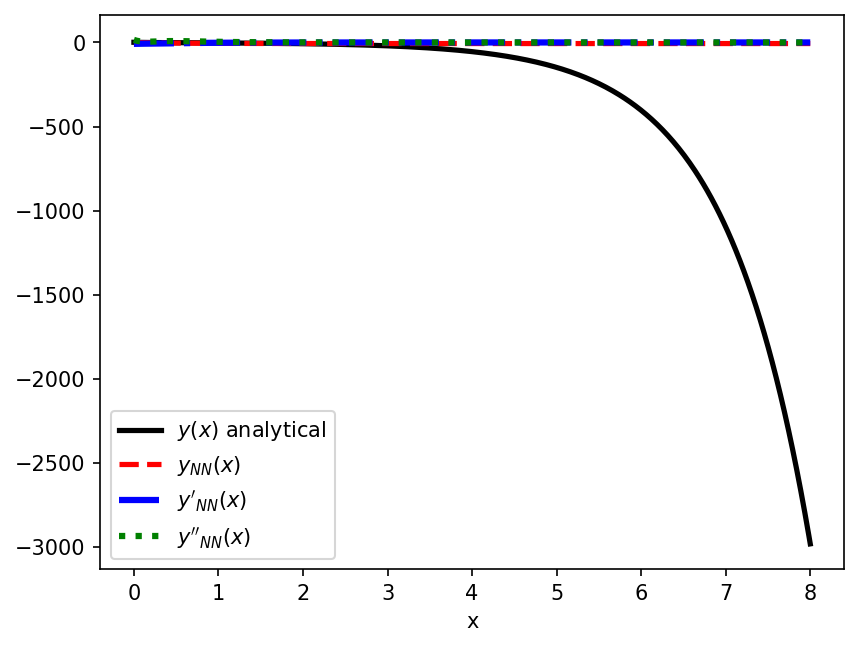

In [8]:
# Check the PINN at different points not included in the training set
n = 500
x=np.linspace(0,8,n)
y_exact=2*tf.exp(-4*x)-tf.exp(x)
y_NN=model.predict(x)

# The gradients (y'(x) and y''(x)) from the model
x_tf = tf.convert_to_tensor(x, dtype=tf.float32)
with tf.GradientTape(persistent=True) as t:
  t.watch(x_tf)
  with tf.GradientTape(persistent=True) as t2:
        t2.watch(x_tf)
        y = model(x_tf)
  dy_dx_NN = t2.gradient(y, x_tf)
d2y_dx2_NN = t.gradient(dy_dx_NN, x_tf)

# Plot the results
plt.rcParams['figure.dpi'] = 150
plt.plot(x, y_exact, color="black",linestyle='solid',
                     linewidth=2.5,label="$y(x)$ analytical")
plt.plot(x, y_NN, color="red",linestyle='dashed',
                  linewidth=2.5, label="$y_{NN}(x)$")
plt.plot(x, dy_dx_NN, color="blue",linestyle='-.',
                  linewidth=3.0, label="$y'_{NN}(x)$")
plt.plot(x, d2y_dx2_NN, color="green", linestyle='dotted',
                  linewidth=3.0, label="$y''_{NN}(x)$")
plt.legend()
plt.xlabel("x")
plt.show()